In [19]:
import os

def rename_images_preserve_format(base_path):
    for root, dirs, files in os.walk(base_path):
        image_count = 1
        for i, filename in enumerate(sorted(files)):
            file_path = os.path.join(root, filename)
            if os.path.isfile(file_path):
                ext = os.path.splitext(filename)[1].lower()
                if ext in [".jpg", ".jpeg", ".png", ".JPG", ".JPEG"]:
                    new_name = f"image_{i+1:04d}{ext}"
                    new_path = os.path.join(root, new_name)
                    os.rename(file_path, new_path)
                    print(f"Renamed {filename} → {new_name}")

rename_images_preserve_format("Pattern_Project")


Renamed image_0001.jpg → image_0001.jpg
Renamed image_0002.jpg → image_0002.jpg
Renamed image_0003.jpg → image_0003.jpg
Renamed image_0004.jpg → image_0004.jpg
Renamed image_0005.jpg → image_0005.jpg
Renamed image_0006.jpg → image_0006.jpg
Renamed image_0007.jpg → image_0007.jpg
Renamed image_0008.jpg → image_0008.jpg
Renamed image_0009.jpg → image_0009.jpg
Renamed image_0010.jpg → image_0010.jpg
Renamed image_0011.jpg → image_0011.jpg
Renamed image_0012.jpg → image_0012.jpg
Renamed image_0013.jpg → image_0013.jpg
Renamed image_0014.jpg → image_0014.jpg
Renamed image_0015.jpg → image_0015.jpg
Renamed image_0016.jpg → image_0016.jpg
Renamed image_0017.jpg → image_0017.jpg
Renamed image_0018.jpg → image_0018.jpg
Renamed image_0019.jpg → image_0019.jpg
Renamed image_0020.jpg → image_0020.jpg
Renamed image_0021.jpg → image_0021.jpg
Renamed image_0022.jpg → image_0022.jpg
Renamed image_0023.jpg → image_0023.jpg
Renamed image_0024.jpg → image_0024.jpg
Renamed image_0025.jpg → image_0025.jpg


In [20]:
import shutil
import random

def split_dataset(base_path, output_path, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    assert abs((train_ratio + val_ratio + test_ratio) - 1.0) < 1e-6, "Ratios must sum to 1."

    classes = os.listdir(base_path)
    
    for cls in classes:
        class_path = os.path.join(base_path, cls)
        if not os.path.isdir(class_path):
            continue
        variations = os.listdir(class_path)
        
        for variation in variations:
            var_path = os.path.join(class_path, variation)
            if not os.path.isdir(var_path):
                continue

            images = [f for f in os.listdir(var_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            random.shuffle(images)

            total = len(images)
            train_end = int(total * train_ratio)
            val_end = train_end + int(total * val_ratio)

            splits = {
                'train': images[:train_end],
                'val': images[train_end:val_end],
                'test': images[val_end:]
            }

            for split, split_images in splits.items():
                split_dir = os.path.join(output_path, split, cls, variation)
                os.makedirs(split_dir, exist_ok=True)

                for img in split_images:
                    src = os.path.join(var_path, img)
                    dst = os.path.join(split_dir, img)
                    shutil.copy2(src, dst)

                print(f"Copied {len(split_images)} images to {split}/{cls}/{variation}")

split_dataset(
    base_path="Pattern_Project",          
    output_path="dataset_split"                 
)


Copied 700 images to train/Blackberry/In a Container
Copied 150 images to val/Blackberry/In a Container
Copied 150 images to test/Blackberry/In a Container
Copied 700 images to train/Blackberry/Single Berry
Copied 150 images to val/Blackberry/Single Berry
Copied 150 images to test/Blackberry/Single Berry
Copied 700 images to train/Blackberry/Small Group
Copied 150 images to val/Blackberry/Small Group
Copied 150 images to test/Blackberry/Small Group
Copied 700 images to train/Lime/In Context
Copied 150 images to val/Lime/In Context
Copied 150 images to test/Lime/In Context
Copied 700 images to train/Lime/Whole
Copied 150 images to val/Lime/Whole
Copied 150 images to test/Lime/Whole
Copied 700 images to train/Lime/Halved
Copied 150 images to val/Lime/Halved
Copied 151 images to test/Lime/Halved


In [31]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  
    transforms.Normalize([0.485, 0.456, 0.406],  
                         [0.229, 0.224, 0.225])
])

data_root = "dataset_split"  

train_data = datasets.ImageFolder(root=f"{data_root}/train", transform=transform)
val_data   = datasets.ImageFolder(root=f"{data_root}/val", transform=transform)
test_data  = datasets.ImageFolder(root=f"{data_root}/test", transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_data, batch_size=32, shuffle=False)

print("Class-to-Index Mapping:", train_data.class_to_idx)


Class-to-Index Mapping: {'Blackberry': 0, 'Lime': 1}


In [32]:
import torch.nn as nn
from torchvision import models
from torch.optim import Adam
from tqdm import tqdm

model = models.resnet18(weights=None)

state_dict = torch.load("resnet18-f37072fd.pth")  
model.load_state_dict(state_dict)

for param in model.parameters():
    param.requires_grad = False

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2) 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.fc.parameters(), lr=0.001)

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct, total = 0, 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        val_acc = evaluate_model(model, val_loader)
        print(f"Train Loss: {total_loss:.4f}, Train Acc: {100*correct/total:.2f}%, Val Acc: {val_acc:.2f}%")

def evaluate_model(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total

train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5)
torch.save(model.state_dict(), "produce_classifier.pth")


Epoch 1/5: 100%|██████████| 132/132 [11:32<00:00,  5.24s/it]


Train Loss: 27.9219, Train Acc: 93.52%, Val Acc: 99.33%


Epoch 2/5: 100%|██████████| 132/132 [11:32<00:00,  5.25s/it]


Train Loss: 9.0022, Train Acc: 99.05%, Val Acc: 99.89%


Epoch 3/5: 100%|██████████| 132/132 [11:21<00:00,  5.17s/it]


Train Loss: 6.1391, Train Acc: 99.29%, Val Acc: 99.22%


Epoch 4/5: 100%|██████████| 132/132 [11:18<00:00,  5.14s/it]


Train Loss: 4.5858, Train Acc: 99.43%, Val Acc: 99.89%


Epoch 5/5: 100%|██████████| 132/132 [11:18<00:00,  5.14s/it]


Train Loss: 4.0268, Train Acc: 99.43%, Val Acc: 100.00%


In [28]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_and_plot(model, test_loader, class_names, model_name):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    print(f"\nClassification Report for {model_name}:\n")
    print(classification_report(y_true, y_pred, target_names=class_names))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()


Classification Report for Produce Classifier:

              precision    recall  f1-score   support

  blackberry       1.00      1.00      1.00       450
        lime       1.00      1.00      1.00       451

    accuracy                           1.00       901
   macro avg       1.00      1.00      1.00       901
weighted avg       1.00      1.00      1.00       901



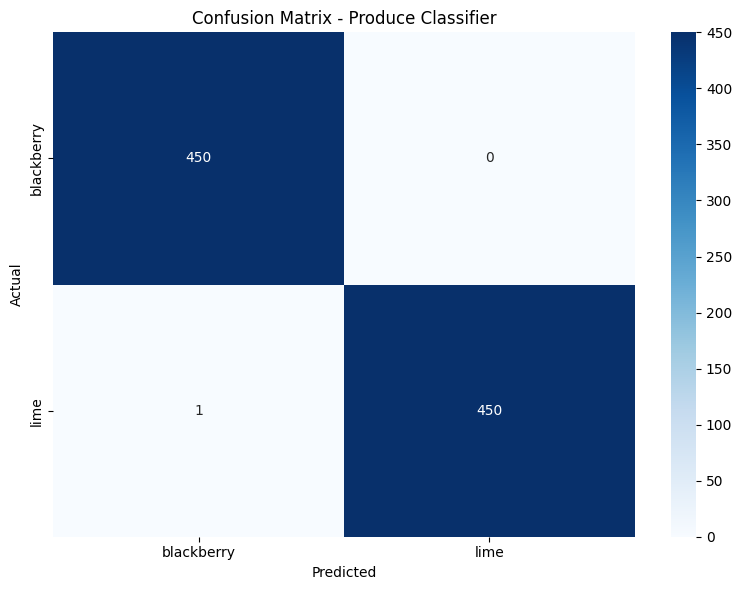

In [33]:
model = models.resnet18(weights=None)
state_dict = torch.load("resnet18-f37072fd.pth")
model.load_state_dict(state_dict)
model.fc = nn.Linear(model.fc.in_features, 2)
model.load_state_dict(torch.load("produce_classifier.pth"))
model = model.to(device)
produce_class_names = ['blackberry', 'lime']
evaluate_and_plot(model, test_loader, produce_class_names, "Produce Classifier")

In [23]:
def split_variation_data(base_path, output_path, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    assert abs((train_ratio + val_ratio + test_ratio) - 1.0) < 1e-6

    variations = os.listdir(base_path)

    for variation in variations:
        var_path = os.path.join(base_path, variation)
        if not os.path.isdir(var_path):
            continue

        images = [f for f in os.listdir(var_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        random.shuffle(images)

        total = len(images)
        train_end = int(total * train_ratio)
        val_end = train_end + int(total * val_ratio)

        splits = {
            'train': images[:train_end],
            'val': images[train_end:val_end],
            'test': images[val_end:]
        }

        for split, split_images in splits.items():
            split_dir = os.path.join(output_path, split, variation)
            os.makedirs(split_dir, exist_ok=True)

            for img in split_images:
                src = os.path.join(var_path, img)
                dst = os.path.join(split_dir, img)
                shutil.copy2(src, dst)

            print(f"Copied {len(split_images)} images to {split}/{variation}")

split_variation_data(
    base_path="variation_data",               
    output_path="variation_dataset_split"     
)


Copied 700 images to train/In Context
Copied 150 images to val/In Context
Copied 150 images to test/In Context
Copied 700 images to train/In a Container
Copied 150 images to val/In a Container
Copied 150 images to test/In a Container
Copied 700 images to train/Whole
Copied 150 images to val/Whole
Copied 150 images to test/Whole
Copied 700 images to train/Single Berry
Copied 150 images to val/Single Berry
Copied 150 images to test/Single Berry
Copied 700 images to train/Small Group
Copied 150 images to val/Small Group
Copied 150 images to test/Small Group
Copied 700 images to train/Halved
Copied 150 images to val/Halved
Copied 151 images to test/Halved


In [24]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from torchvision import models
from torch.optim import Adam
from tqdm import tqdm

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

data_root = "variation_dataset_split"
train_data = datasets.ImageFolder(root=f"{data_root}/train", transform=transform)
val_data   = datasets.ImageFolder(root=f"{data_root}/val", transform=transform)
test_data  = datasets.ImageFolder(root=f"{data_root}/test", transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_data, batch_size=32, shuffle=False)

print("Class mapping:", train_data.class_to_idx)

model = models.resnet18(weights=None)
state_dict = torch.load("resnet18-f37072fd.pth")
model.load_state_dict(state_dict)

for param in model.parameters():
    param.requires_grad = False

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 6)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.fc.parameters(), lr=0.001)

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        model.train()
        correct, total, total_loss = 0, 0, 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        val_acc = evaluate_model(model, val_loader)
        print(f"Train Loss: {total_loss:.4f}, Train Acc: {100*correct/total:.2f}%, Val Acc: {val_acc:.2f}%")

def evaluate_model(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total

train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5)

torch.save(model.state_dict(), "variation_classifier.pth")


Class mapping: {'Halved': 0, 'In Context': 1, 'In a Container': 2, 'Single Berry': 3, 'Small Group': 4, 'Whole': 5}


Epoch 1/5: 100%|██████████| 132/132 [11:30<00:00,  5.23s/it]


Train Loss: 81.9809, Train Acc: 84.67%, Val Acc: 97.11%


Epoch 2/5: 100%|██████████| 132/132 [11:32<00:00,  5.24s/it]


Train Loss: 22.2962, Train Acc: 97.50%, Val Acc: 99.11%


Epoch 3/5: 100%|██████████| 132/132 [11:23<00:00,  5.18s/it]


Train Loss: 14.0002, Train Acc: 98.40%, Val Acc: 98.89%


Epoch 4/5: 100%|██████████| 132/132 [11:26<00:00,  5.20s/it]


Train Loss: 9.5789, Train Acc: 98.98%, Val Acc: 99.22%


Epoch 5/5: 100%|██████████| 132/132 [11:27<00:00,  5.21s/it]


Train Loss: 7.8245, Train Acc: 99.19%, Val Acc: 99.22%


Variation Classifier


Classification Report for Variation Classifier:

                precision    recall  f1-score   support

        Halved       0.99      0.99      0.99       151
    In Context       0.99      0.99      0.99       150
In a Container       1.00      1.00      1.00       150
  Single Berry       0.99      1.00      1.00       150
   Small Group       1.00      0.99      1.00       150
         Whole       0.99      1.00      0.99       150

      accuracy                           0.99       901
     macro avg       0.99      0.99      0.99       901
  weighted avg       0.99      0.99      0.99       901



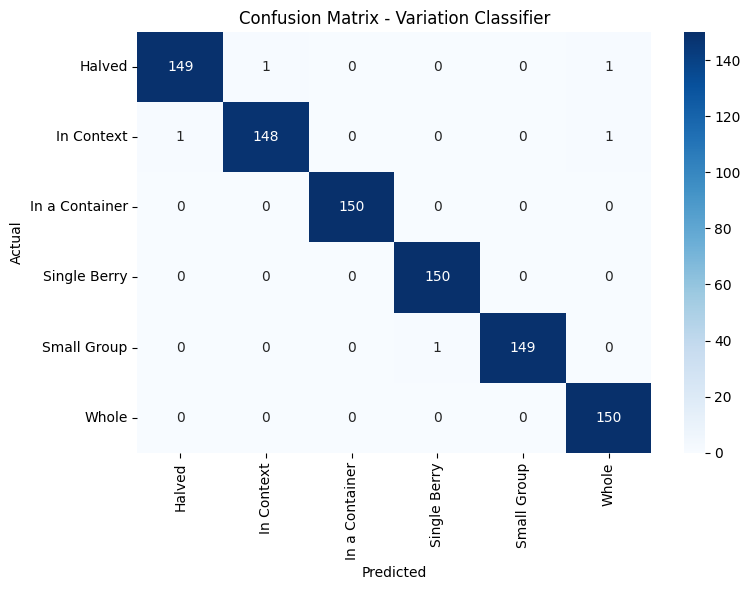

In [27]:
model = models.resnet18(weights=None)
state_dict = torch.load("resnet18-f37072fd.pth")
model.load_state_dict(state_dict)
model.fc = nn.Linear(model.fc.in_features, 6)
model.load_state_dict(torch.load("variation_classifier.pth"))
model = model.to(device)

variation_class_names = ['Halved', 'In Context', 'In a Container', 'Single Berry', 'Small Group', 'Whole']

evaluate_and_plot(model, test_loader, variation_class_names, "Variation Classifier")


In [35]:
import gradio as gr
import torch
from torchvision import models, transforms
from PIL import Image
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"

produce_model = models.resnet18(weights=None)
produce_model.fc = nn.Linear(produce_model.fc.in_features, 2)
produce_model.load_state_dict(torch.load("produce_classifier.pth", map_location=device))
produce_model.eval().to(device)

variation_model = models.resnet18(weights=None)
variation_model.fc = nn.Linear(variation_model.fc.in_features, 6)
variation_model.load_state_dict(torch.load("variation_classifier.pth", map_location=device))
variation_model.eval().to(device)

produce_classes = ['blackberry', 'lime']
variation_classes = ['Halved', 'In Context', 'In a Container', 'Single Berry', 'Small Group', 'Whole']

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

def classify(image):
    image = Image.fromarray(image).convert("RGB")
    img_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        pred1 = produce_model(img_tensor)
        pred2 = variation_model(img_tensor)

    prod_label = produce_classes[torch.argmax(pred1).item()]
    var_label = variation_classes[torch.argmax(pred2).item()]
    return f"Produce: {prod_label}", f"Variation: {var_label}"

demo = gr.Interface(fn=classify,
                    inputs=gr.Image(type="numpy"),
                    outputs=["text", "text"],
                    title="Blackberry & Lime Classifier",
                    description="Upload a produce image to get predictions for type and variation.")

demo.launch()


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


Created dataset file at: .gradio/flagged/dataset1.csv
